In [222]:
import pandas as pd

data = pd.read_csv("DataFiles/Exp2.csv", header='infer')

In [223]:
def remove_unwated_columns(data):
    return data.drop(['Name', 'Created'], axis=1)

def get_rows_with_col_value(data, col, value):
    return data[data[col] == value]

def remove_top1_under(data, threshold):
    return data[data['Top1'] >= threshold]

In [224]:
data = remove_unwated_columns(data)
finished_runs = get_rows_with_col_value(data, 'State', 'finished')
finished_runs 


,State,filter_pruner_20,filter_pruner_40,filter_pruner_60,filter_pruner_70,Latency,Loss,Throughput,Top1,Top5,Total_Latency
0,finished,0.739484,0.168035,0.381474,0.777567,3.968,0.516,296.96,87.75,99.57,13.35
2,finished,0.216842,0.761098,0.734318,0.965526,3.499,0.541,318.06,84.90,99.35,12.43
3,finished,0.153316,0.937679,0.898108,0.923152,3.349,0.514,307.68,86.00,99.40,12.80
4,finished,0.521988,0.582726,0.782334,0.974747,3.656,0.530,306.05,85.93,99.22,12.81
5,finished,0.894671,0.396051,0.240471,0.514597,4.014,0.543,305.59,87.68,99.51,12.91
...,...,...,...,...,...,...,...,...,...,...,...
288,finished,0.787431,0.129487,0.947149,0.481372,3.978,0.542,304.12,87.94,99.56,12.95
289,finished,0.541767,0.183427,0.750033,0.433422,4.270,0.516,301.02,87.71,99.55,12.99
290,finished,0.589320,0.191070,0.756625,0.410329,3.993,0.540,285.78,87.96,99.58,13.09
291,finished,0.575509,0.538834,0.455484,0.103702,4.152,0.549,305.77,87.84,99.46,12.91


In [225]:
# Count number of failed experiements
# Count number of experiments with a top1==100/|classes|
# Remove name, agent, notes, user, tags, created, sweep columns
# Find how reducing the inference latency effects the total latency

In [226]:
latency_data = finished_runs.drop(['State'], axis=1)
latency_data = remove_top1_under(latency_data, 60)

In [227]:


# Correlation between Inference Latency and the Total Latency
il_tl_corr = latency_data['Latency'].corr(latency_data['Total_Latency'])

# Correlations between each pruner and the inference Latency
fp_20_corr = latency_data['filter_pruner_20'].corr(latency_data['Latency'])
fp_40_corr = latency_data['filter_pruner_40'].corr(latency_data['Latency'])
fp_60_corr = latency_data['filter_pruner_60'].corr(latency_data['Latency'])
fp_70_corr = latency_data['filter_pruner_70'].corr(latency_data['Latency'])

correlations = pd.DataFrame([(fp_20_corr, fp_40_corr, fp_60_corr, fp_70_corr, il_tl_corr)], columns=['fp_20', 'fp_40', 'fp_60', 'fp_70', 'latency_to_total'])
correlations

,fp_20,fp_40,fp_60,fp_70,latency_to_total
0,-0.138894,-0.503688,-0.500734,-0.827473,0.587054


In [228]:
# Correlation between Latency and top1
t1_il_corr = latency_data['Latency'].corr(latency_data['Top1'])

# Correlations between each pruner and Top1
t1_fp_20_corr = latency_data['filter_pruner_20'].corr(latency_data['Top1'])
t1_fp_40_corr = latency_data['filter_pruner_40'].corr(latency_data['Top1'])
t1_fp_60_corr = latency_data['filter_pruner_60'].corr(latency_data['Top1'])
t1_fp_70_corr = latency_data['filter_pruner_70'].corr(latency_data['Top1'])

t1_correlations = pd.DataFrame([(t1_fp_20_corr, t1_fp_40_corr, t1_fp_60_corr, t1_fp_70_corr, t1_il_corr)], columns=['fp_20', 'fp_40', 'fp_60', 'fp_70', 'latency_to_Top1'])
t1_correlations


,fp_20,fp_40,fp_60,fp_70,latency_to_Top1
0,-0.086224,-0.441157,-0.451589,-0.804794,0.822323


In [229]:
import matplotlib.pyplot as plt
import numpy as np
import math

str_to_index = {'Latency': 4, 'Loss': 5, 'Throughput': 6, 'Top1': 7, 'Top5': 8, 'Total_Latency': 9, 'PCA':10}

def get_bin_type_index(name):
    bin_type_dict = {'mean': 1, 'max': 2, 'min': 3}
    bin_type = bin_type_dict.get(name)
    if bin_type is None:
        raise ValueError('Invalid bin type. Choose one of: [mean, min, max]')
    return bin_type

def build_line(nparray, col_index, against_index):
    x_vals = nparray[:,col_index]
    y_vals = nparray[:,against_index]
    return zip(*sorted(zip(x_vals, y_vals))) # x and y values, sorted by x


def plot_pruners(dataframe, against: str, title, bin_type='mean'):
    # X axis will be 0 - 1 float of pruner setting
    # Y axis is the against string

    bin_type = get_bin_type_index(bin_type)


    bin_var = 0.04

    y_axis_index = str_to_index.get(against)
    if y_axis_index is None:
        raise ValueError('Againt value not mapped to a column in the data')

    fp_20 = sorted(build_line(dataframe.to_numpy(), 0, y_axis_index))
    val_tuple = bin_to_param_step(fp_20, bin_var)
    fp_20 = zip(val_tuple[0].tolist(), val_tuple[bin_type].tolist())

    fp_40 = sorted(build_line(dataframe.to_numpy(), 1, y_axis_index))
    val_tuple = bin_to_param_step(fp_40, bin_var)
    fp_40 = zip(val_tuple[0].tolist(), val_tuple[bin_type].tolist())

    fp_60 = sorted(build_line(dataframe.to_numpy(), 2, y_axis_index))
    val_tuple = bin_to_param_step(fp_60, bin_var)
    fp_60 = zip(val_tuple[0].tolist(), val_tuple[bin_type].tolist())

    fp_70 = sorted(build_line(dataframe.to_numpy(), 3, y_axis_index))
    val_tuple = bin_to_param_step(fp_70, bin_var)
    fp_70 = zip(val_tuple[0].tolist(), val_tuple[bin_type].tolist())

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(*zip(*fp_20), label='Filter Pruner Layer 3.1')
    ax.plot(*zip(*fp_40), label='Filter Pruner Layer 3.2')
    ax.plot(*zip(*fp_60), label='Filter Pruner Layer 2')
    ax.plot(*zip(*fp_70), label='Filter Pruner Layer 1')

    ax.set_title(title, fontsize=25)
    ax.set_ylabel(against, fontsize=20)
    ax.set_xlabel('Target Sparsity', fontsize=20)

    ax.legend(prop={"size":16})
    plt.tight_layout()
    plt.show()




def bin_to_param_step(data, step_size: float):
    assert step_size < 1
    assert step_size > 0
    assert 100%(step_size*100) == 0

    x, y = data
    value = np.array(y)
    parameter = np.array(x)

    num_groups = math.floor(100 / (step_size*100))

    binned_mean_value = np.zeros(num_groups)
    binned_max_value = np.zeros(num_groups)
    binned_min_value = np.zeros(num_groups)
    binned_parameters = np.zeros(num_groups)


    for i in range(num_groups):
        start = i * 1/num_groups
        stop = start + 1/num_groups
        # get the min within start & stop. value, not index

        indices = np.intersect1d(np.where(parameter > start), np.where(parameter < stop))

        binned_mean_value[i] = np.mean(value[indices])
        if len(indices) > 0:
            binned_max_value[i] = np.amax(value[indices])
            binned_min_value[i] = np.amin(value[indices])
        binned_parameters[i] = start

    return binned_parameters, binned_mean_value, binned_max_value, binned_min_value


def bin_data(data, target_num_groups):
    x, y = data
    data_per_bin = int(math.ceil(len(x)/target_num_groups))
    value = np.array(y)
    parameter = np.array(x)
    
    binned_mean_value = np.zeros(target_num_groups)
    binned_max_value = np.zeros(target_num_groups)
    binned_min_value = np.zeros(target_num_groups)
    binned_parameters = np.zeros(target_num_groups)

    actual_groups = 0

    for i in range(target_num_groups):
        start = i * data_per_bin
        stop = start + data_per_bin - 1
        if (stop > len(x)):
            actual_groups = i
            break
        else:
            actual_groups = i
        binned_mean_value[i] = np.mean(value[start : stop])
        binned_max_value[i] = np.amax(value[start : stop])
        binned_min_value[i] = np.amin(value[start : stop])
        binned_parameters[i] = np.mean(parameter[start : stop])

    binned_mean_value = binned_mean_value[0:actual_groups]
    binned_max_value = binned_max_value[0:actual_groups]
    binned_min_value = binned_min_value[0:actual_groups]
    binned_parameters = binned_parameters[0:actual_groups]

    return binned_parameters, binned_mean_value, binned_max_value, binned_min_value



In [230]:
100%5

0

C:\Users\fried\.conda\envs\DissertationVis\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\fried\.conda\envs\DissertationVis\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


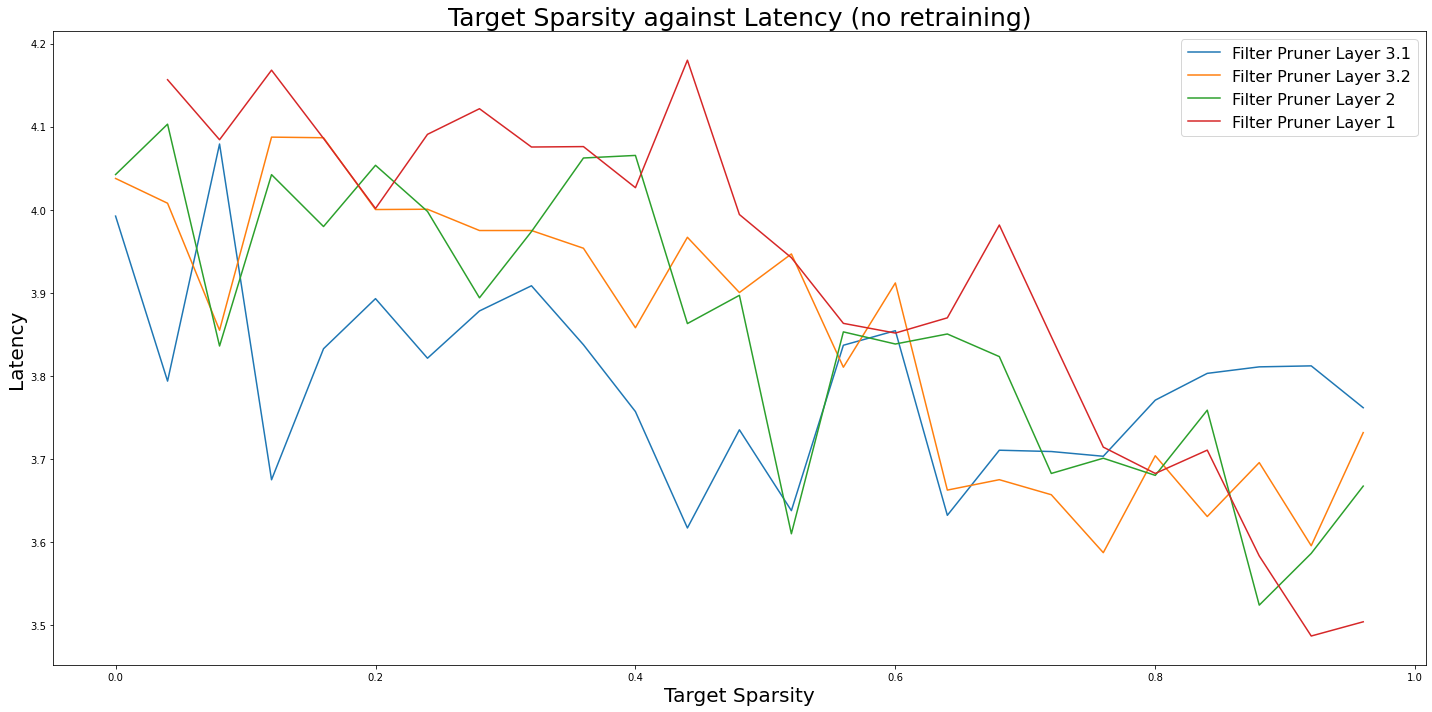

In [231]:
plot_pruners(latency_data, 'Latency', 'Target Sparsity against Latency (no retraining)', 'mean')

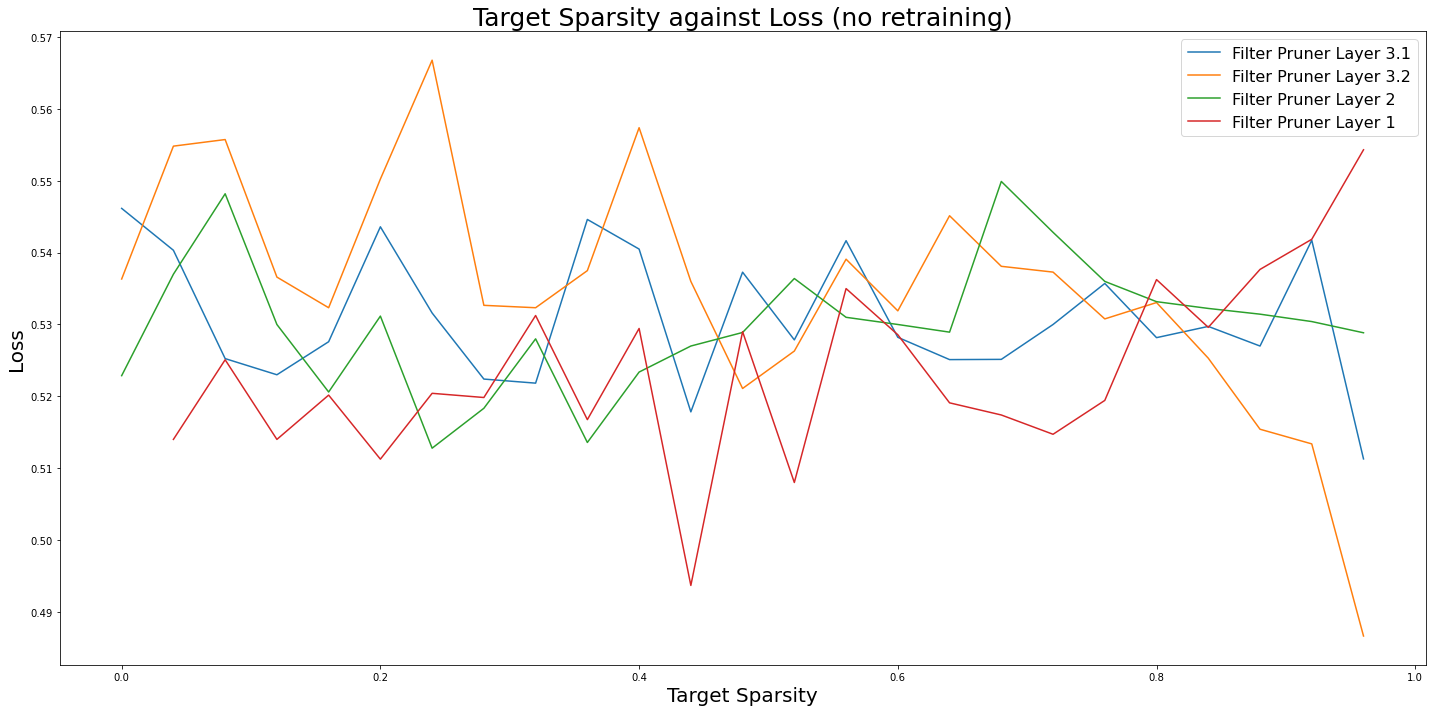

In [232]:
plot_pruners(latency_data, 'Loss', 'Target Sparsity against Loss (no retraining)')

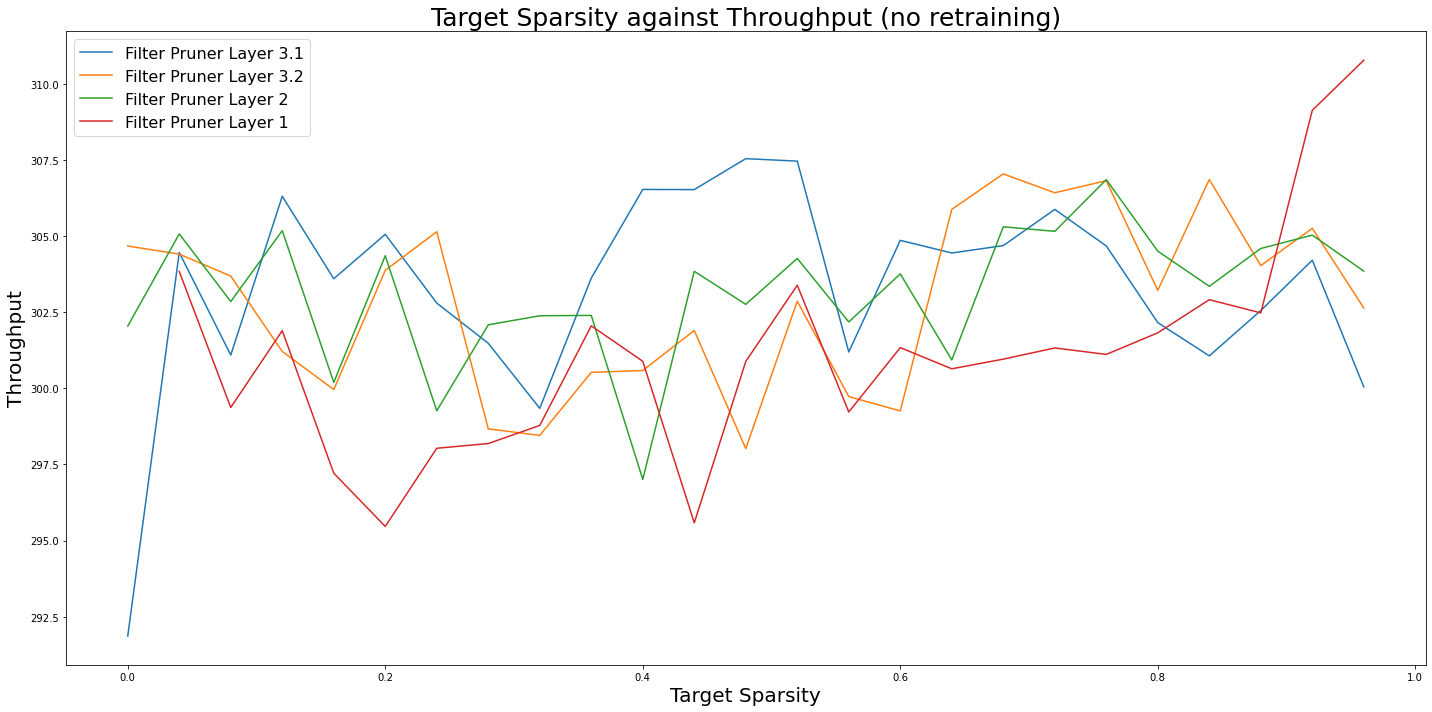

In [233]:
plot_pruners(latency_data, 'Throughput', 'Target Sparsity against Throughput (no retraining)')

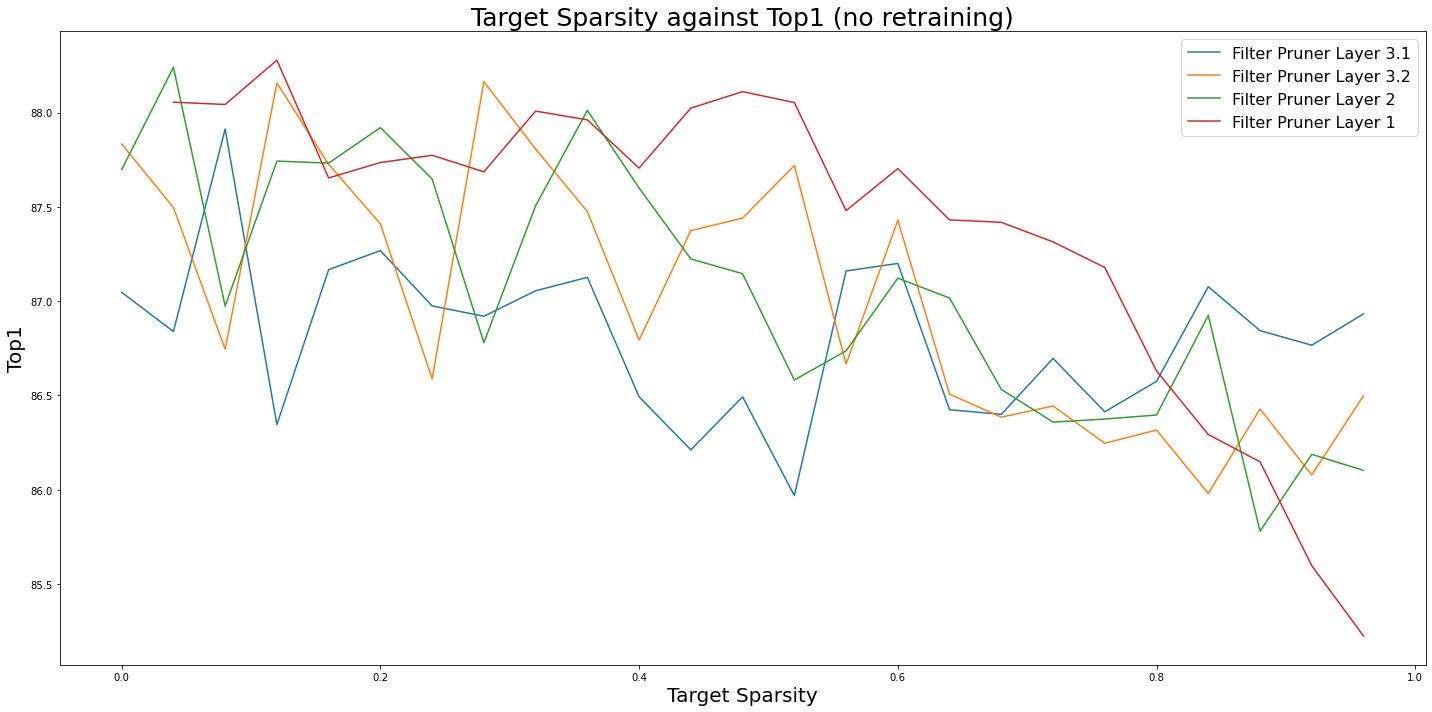

In [234]:
plot_pruners(latency_data, 'Top1', 'Target Sparsity against Top1 (no retraining)', 'mean')

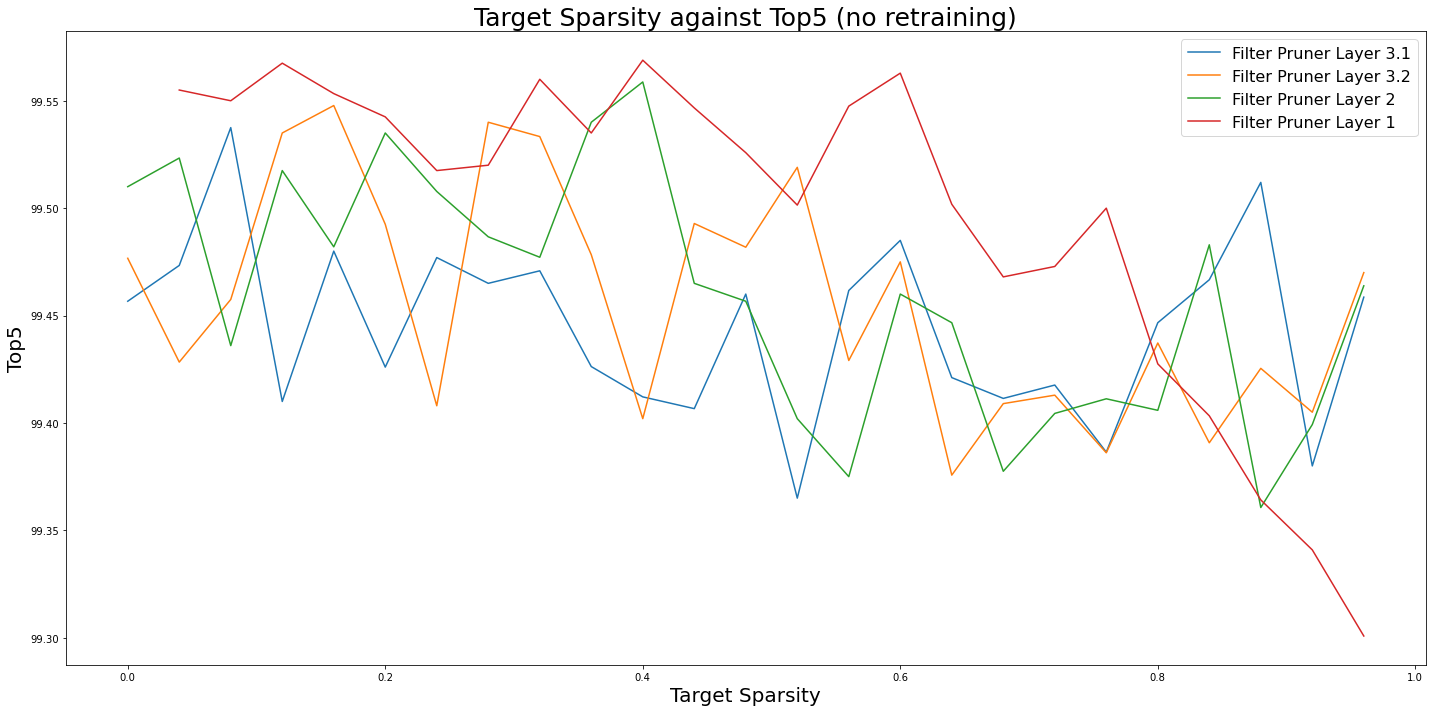

In [235]:
plot_pruners(latency_data, 'Top5', 'Target Sparsity against Top5 (no retraining)')

In [236]:
    from matplotlib import cm
    
    def plot_surface(pruner_index, data, param_name='Target sparsity', latency_col_index=4, top1_col_index=7):
    
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
        ax.set_xlabel('Latency')
        ax.set_ylabel('Top1')
        ax.set_zlabel(param_name)
        #ax.plot_wireframe(cParams, gammas, avg_errors_array)
        #ax.plot3D(cParams, gammas, avg_errors_array)
        #ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')


        surf = ax.plot_trisurf(data.iloc[:, latency_col_index],  data.iloc[:, top1_col_index], data.iloc[:, pruner_index], cmap=cm.jet, linewidth=0.1)
        fig.colorbar(surf, shrink=0.5, aspect=5)    
        #ax.invert_xaxis()
        #ax.invert_yaxis()
        #ax.set_xlim(4.5, 3.2)
        ax.set_ylim(90, 84)
        #plt.savefig('./plots/avgErrs_vs_C_andgamma_type_%s.png'%(k))
        plt.show()

In [237]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Latency: 4
# Top1 : 7
t_latency = latency_data.iloc[:,4]
t_Top1 = latency_data.iloc[:,7]
results = pd.concat([t_latency, t_Top1], axis=1, join='inner')

norm_results = StandardScaler().fit_transform(results)

In [238]:
filters = latency_data.iloc[:,0:5]
norm_filters = StandardScaler().fit_transform(filters)
pca_f = PCA(n_components=1)
pca_filters = pca_f.fit_transform(norm_filters)

pca_df_filters = pd.concat([pd.DataFrame(pca_filters, columns=['PCA_filters']), results], axis=1, join='inner')
pca_f.explained_variance_ratio_

array([0.48900358])

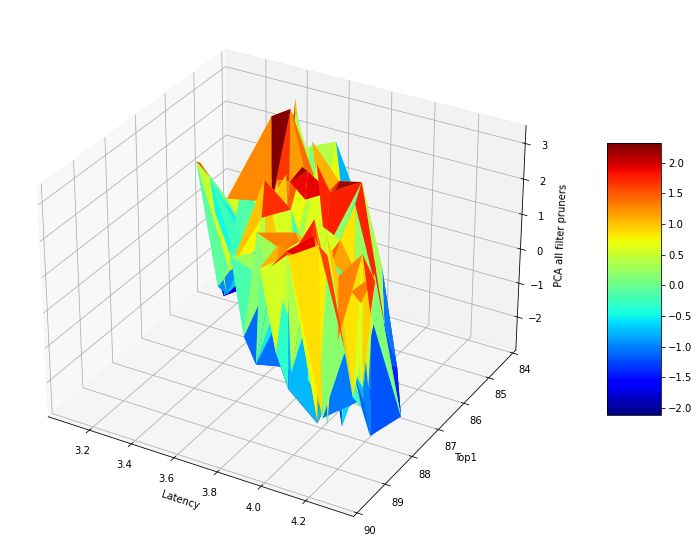

In [239]:
plot_surface(0, pca_df_filters, param_name='PCA all filter pruners', latency_col_index=1, top1_col_index=2)

C:\Users\fried\.conda\envs\DissertationVis\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\fried\.conda\envs\DissertationVis\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


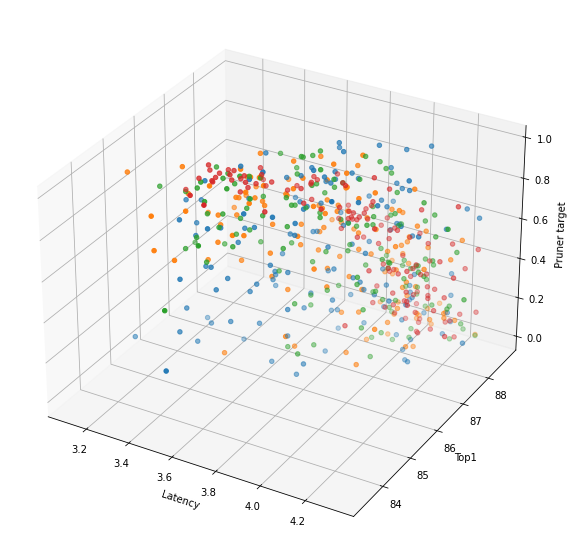

In [240]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')


for i in range(4):
    fp = sorted(build_line(latency_data.to_numpy(), i, 4))
    x, y, z, w = bin_to_param_step(fp, 0.005)

    fp = sorted(build_line(latency_data.to_numpy(), i, 7))
    x, y_hat, z, w = bin_to_param_step(fp, 0.005)
    xs = y # array n elements long
    ys = y_hat
    zs = x
    ax.scatter(xs, ys, zs)

ax.set_xlabel('Latency')
ax.set_ylabel('Top1')
ax.set_zlabel('Pruner target')

plt.show()

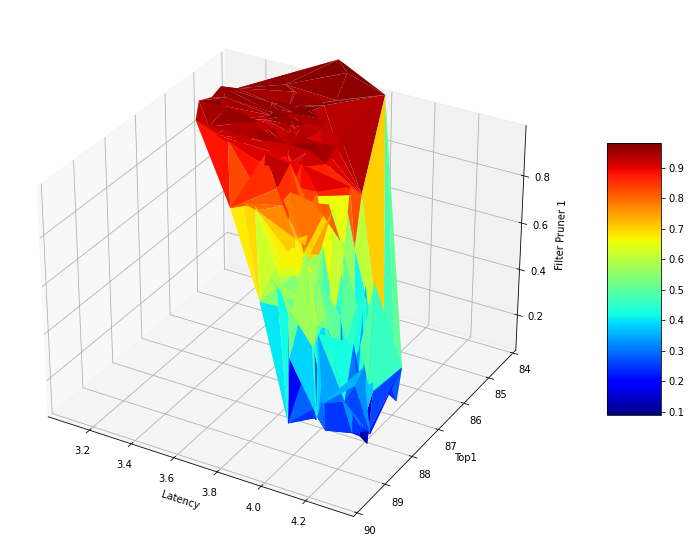

In [241]:
plot_surface(3, latency_data, param_name='Filter Pruner 1')

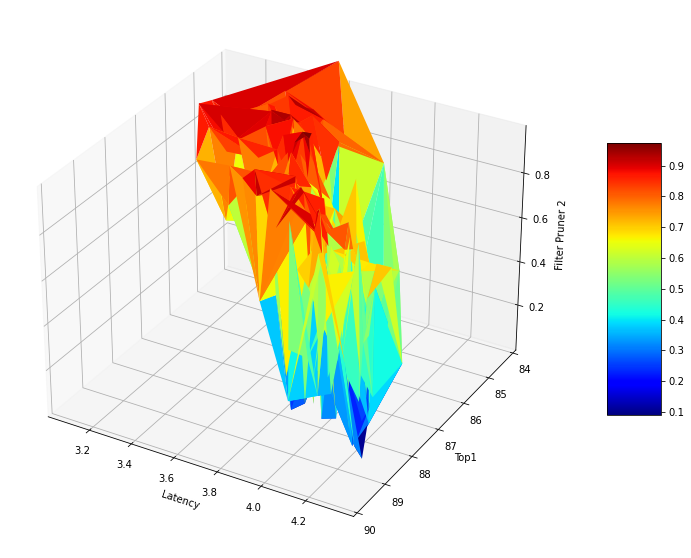

In [242]:
plot_surface(2, latency_data, param_name='Filter Pruner 2')

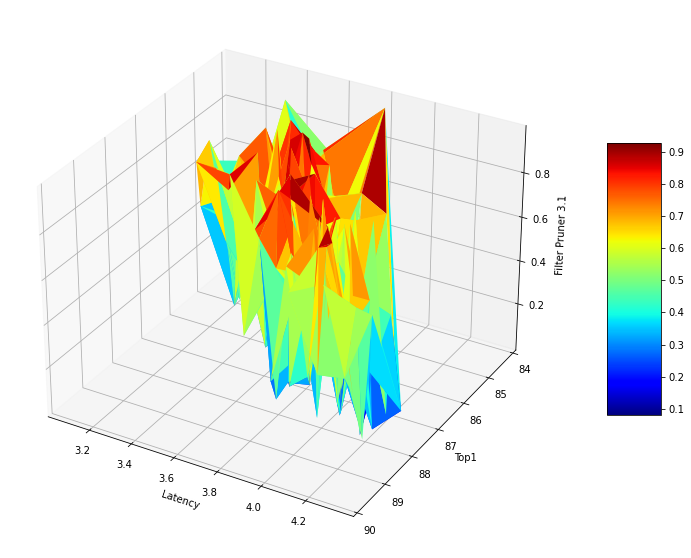

In [243]:
plot_surface(0, latency_data, param_name='Filter Pruner 3.1')

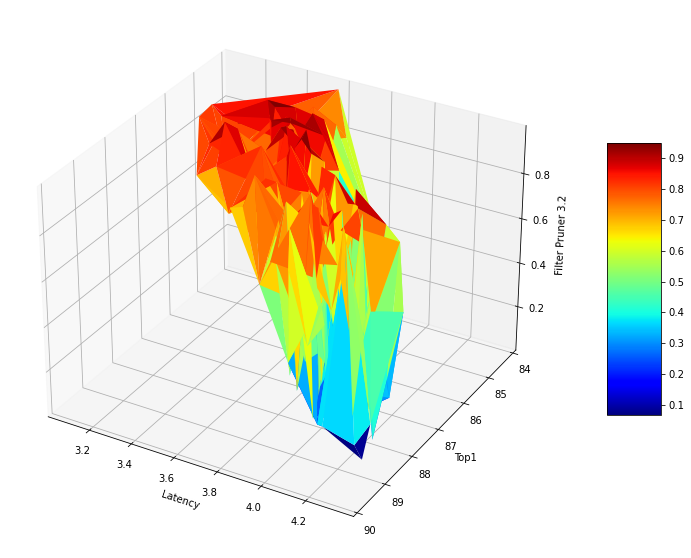

In [244]:
plot_surface(1, latency_data, param_name='Filter Pruner 3.2')

In [245]:
data = pd.read_csv("DataFiles/Exp2.csv", header='infer')
data

,Name,State,Created,filter_pruner_20,filter_pruner_40,filter_pruner_60,filter_pruner_70,Latency,Loss,Throughput,Top1,Top5,Total_Latency
0,fanciful-sweep-293,finished,2021-04-17T23:57:24.000Z,0.739484,0.168035,0.381474,0.777567,3.968,0.516,296.96,87.75,99.57,13.35
1,fresh-sweep-292,failed,2021-04-17T23:57:08.000Z,0.420846,0.893116,0.737389,0.040685,NaN,NaN,NaN,NaN,NaN,NaN
2,lemon-sweep-291,finished,2021-04-17T23:53:45.000Z,0.216842,0.761098,0.734318,0.965526,3.499,0.541,318.06,84.90,99.35,12.43
3,effortless-sweep-290,finished,2021-04-17T23:39:42.000Z,0.153316,0.937679,0.898108,0.923152,3.349,0.514,307.68,86.00,99.40,12.80
4,generous-sweep-289,finished,2021-04-17T23:29:50.000Z,0.521988,0.582726,0.782334,0.974747,3.656,0.530,306.05,85.93,99.22,12.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,dutiful-sweep-5,finished,2021-04-16T00:49:54.000Z,0.787431,0.129487,0.947149,0.481372,3.978,0.542,304.12,87.94,99.56,12.95
289,swift-sweep-4,finished,2021-04-16T00:49:32.000Z,0.541767,0.183427,0.750033,0.433422,4.270,0.516,301.02,87.71,99.55,12.99
290,playful-sweep-3,finished,2021-04-16T00:29:44.000Z,0.589320,0.191070,0.756625,0.410329,3.993,0.540,285.78,87.96,99.58,13.09
291,desert-sweep-2,finished,2021-04-16T00:19:43.000Z,0.575509,0.538834,0.455484,0.103702,4.152,0.549,305.77,87.84,99.46,12.91


In [246]:
sweep = get_rows_with_col_value(data, 'State', 'finished').drop(['State', 'Created'], axis=1)
sweep = remove_top1_under(sweep, 60)
sweep

,Name,filter_pruner_20,filter_pruner_40,filter_pruner_60,filter_pruner_70,Latency,Loss,Throughput,Top1,Top5,Total_Latency
0,fanciful-sweep-293,0.739484,0.168035,0.381474,0.777567,3.968,0.516,296.96,87.75,99.57,13.35
2,lemon-sweep-291,0.216842,0.761098,0.734318,0.965526,3.499,0.541,318.06,84.90,99.35,12.43
3,effortless-sweep-290,0.153316,0.937679,0.898108,0.923152,3.349,0.514,307.68,86.00,99.40,12.80
4,generous-sweep-289,0.521988,0.582726,0.782334,0.974747,3.656,0.530,306.05,85.93,99.22,12.81
5,golden-sweep-288,0.894671,0.396051,0.240471,0.514597,4.014,0.543,305.59,87.68,99.51,12.91
...,...,...,...,...,...,...,...,...,...,...,...
288,dutiful-sweep-5,0.787431,0.129487,0.947149,0.481372,3.978,0.542,304.12,87.94,99.56,12.95
289,swift-sweep-4,0.541767,0.183427,0.750033,0.433422,4.270,0.516,301.02,87.71,99.55,12.99
290,playful-sweep-3,0.589320,0.191070,0.756625,0.410329,3.993,0.540,285.78,87.96,99.58,13.09
291,desert-sweep-2,0.575509,0.538834,0.455484,0.103702,4.152,0.549,305.77,87.84,99.46,12.91


In [247]:
sweep = sweep.reindex(index=sweep.index[::-1]).reset_index().drop(['index'], axis=1)
sweep

,Name,filter_pruner_20,filter_pruner_40,filter_pruner_60,filter_pruner_70,Latency,Loss,Throughput,Top1,Top5,Total_Latency
0,pretty-sweep-1,0.177695,0.653638,0.494821,0.063041,4.230,0.526,302.86,88.17,99.56,13.00
1,desert-sweep-2,0.575509,0.538834,0.455484,0.103702,4.152,0.549,305.77,87.84,99.46,12.91
2,playful-sweep-3,0.589320,0.191070,0.756625,0.410329,3.993,0.540,285.78,87.96,99.58,13.09
3,swift-sweep-4,0.541767,0.183427,0.750033,0.433422,4.270,0.516,301.02,87.71,99.55,12.99
4,dutiful-sweep-5,0.787431,0.129487,0.947149,0.481372,3.978,0.542,304.12,87.94,99.56,12.95
...,...,...,...,...,...,...,...,...,...,...,...
246,golden-sweep-288,0.894671,0.396051,0.240471,0.514597,4.014,0.543,305.59,87.68,99.51,12.91
247,generous-sweep-289,0.521988,0.582726,0.782334,0.974747,3.656,0.530,306.05,85.93,99.22,12.81
248,effortless-sweep-290,0.153316,0.937679,0.898108,0.923152,3.349,0.514,307.68,86.00,99.40,12.80
249,lemon-sweep-291,0.216842,0.761098,0.734318,0.965526,3.499,0.541,318.06,84.90,99.35,12.43


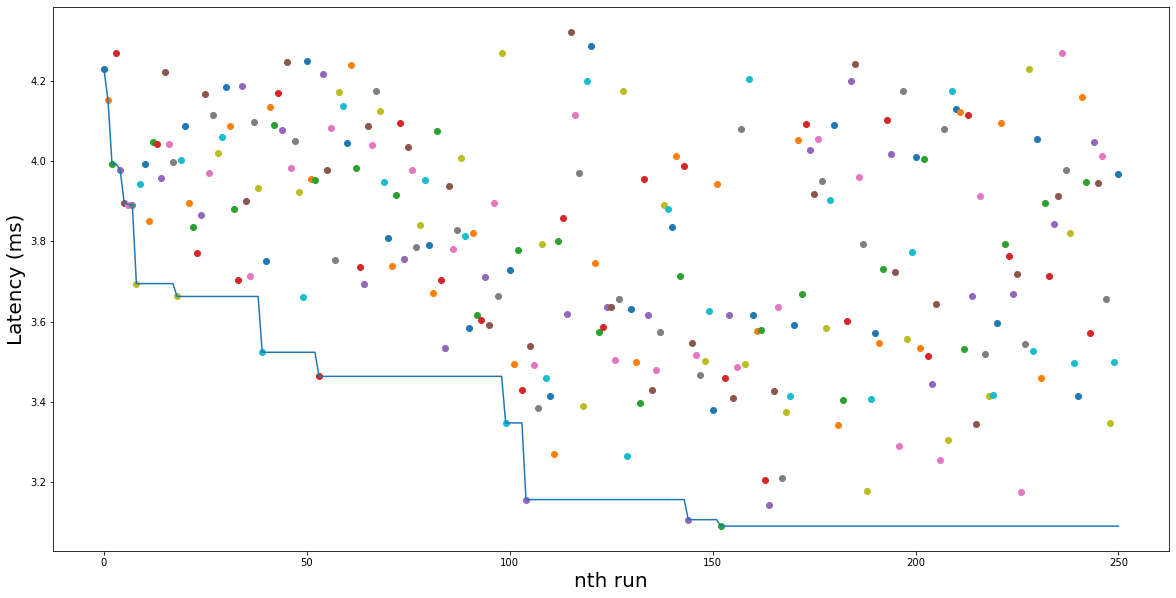

In [248]:
best_line = []
previous_best = 99999

fig, ax = plt.subplots(figsize=(20,10))
for row in sweep.iloc[:, 5].items():
    if row[1] < previous_best:
        best_line.append(row[1])
        previous_best = row[1]
    else:
        best_line.append(previous_best)

    ax.scatter(row[0], row[1])
ax.plot(best_line)
ax.set_ylabel('Latency (ms)', fontsize=20)
ax.set_xlabel('nth run', fontsize=20)

plt.show()


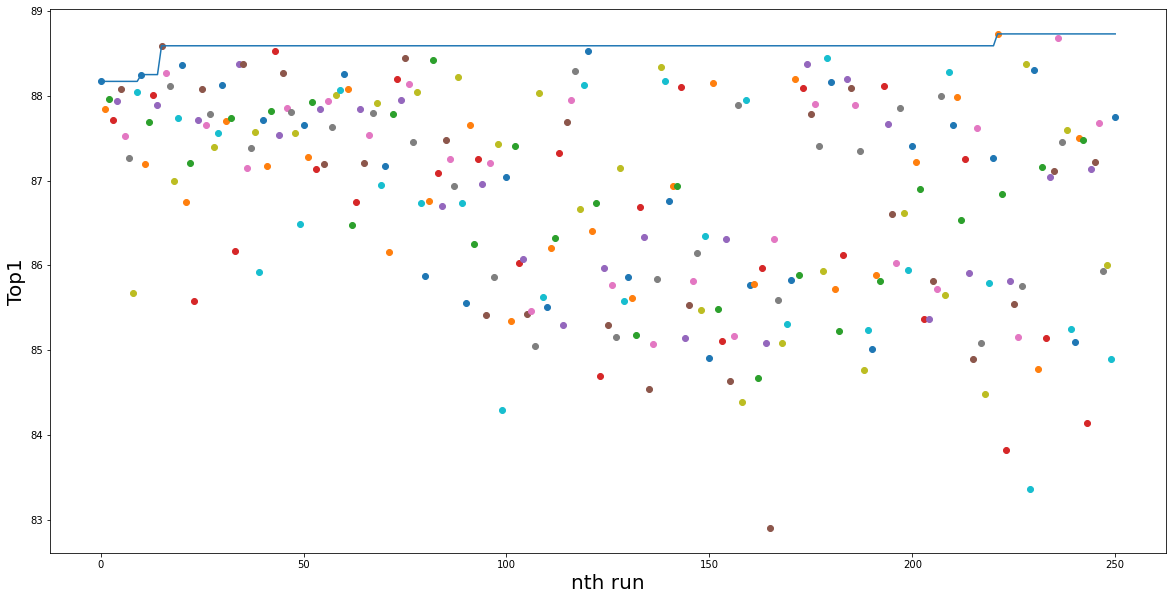

In [249]:
best_line = []
previous_best = 0

fig, ax = plt.subplots(figsize=(20,10))
for row in sweep.iloc[:, 8].items():
    if row[1] > previous_best:
        best_line.append(row[1])
        previous_best = row[1]
    else:
        best_line.append(previous_best)

    ax.scatter(row[0], row[1])
ax.plot(best_line)
ax.set_ylabel('Top1', fontsize=20)
ax.set_xlabel('nth run', fontsize=20)

plt.show()